In [41]:
datasets = ['CUB', 'Derm7pt', 'RIVAL10']
use_dataset = datasets[1]

In [42]:
import os
import sys
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from src.config import PROJECT_ROOT, CUB_CONFIG, DERM7PT_CONFIG, RIVAL10_CONFIG  # noqa: E402
import numpy as np  # noqa: E402

In [43]:
if use_dataset == 'CUB':
    config_dict = CUB_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'CUB')
elif use_dataset == 'Derm7pt':
    config_dict = DERM7PT_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'Derm7pt')
else:
    config_dict = RIVAL10_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'RIVAL10')

In [44]:
num_concepts = config_dict['N_TRIMMED_CONCEPTS']
num_classes = config_dict['N_CLASSES']

# Load and Transform Data

In [45]:
C_hat_train = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_train.npy'))
one_hot_Y_train = np.load(os.path.join(DATASET_PATH, 'Y_train.npy'))

C_hat_test = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_test.npy'))
one_hot_Y_test = np.load(os.path.join(DATASET_PATH, 'Y_test.npy'))

if use_dataset == 'Derm7pt':
    C_hat_val = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_val.npy'))
    one_hot_Y_val = np.load(os.path.join(DATASET_PATH, 'Y_val.npy'))

    C_hat_train = np.concatenate((C_hat_train, C_hat_val), axis=0)
    one_hot_Y_train = np.concatenate((one_hot_Y_train, one_hot_Y_val), axis=0)

class_level_concepts = np.load(os.path.join(DATASET_PATH, 'class_level_concepts.npy'))

In [46]:
Y_train = np.argmax(one_hot_Y_train, axis=1)
Y_test = np.argmax(one_hot_Y_test, axis=1)

In [47]:
C_train = []
for y in Y_train:
    C_train.append(class_level_concepts[y])

C_train = np.array(C_train)

### Create DataLoaders for Prototypes Model

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create Dataloaders
random_seed = 1

def get_loaders(C_hat_train, C_hat_test):
    if use_dataset == 'Derm7pt':
        X_train = torch.tensor(C_hat_train, dtype=torch.float32)
        Y_train = torch.tensor(one_hot_Y_train, dtype=torch.float32)
    else:
        X_train = torch.tensor(C_hat_train, dtype=torch.float32)
        Y_train = torch.tensor(one_hot_Y_train, dtype=torch.float32)

    X_test = torch.tensor(C_hat_test, dtype=torch.float32, device=device)
    Y_test = torch.tensor(one_hot_Y_test, dtype=torch.float32, device=device)

    # DATALOADERS
    batch_size = 64
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # test_dataset = TensorDataset(X_test, Y_test)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, X_test, Y_test

Using device: mps


# Add Noise to Concept Probabilities

In [49]:
def add_noise_to_concepts(c_hat, noise_level, random_seed=42):
    np.random.seed(random_seed)
    c_hat_noisy = c_hat.copy()

    total_values = c_hat.size
    values_to_modify = int(total_values * noise_level)

    # Get flat indices for high and low values
    flat_c_hat = c_hat.flatten()
    all_indices = np.arange(len(flat_c_hat))
    selected_indices = np.random.choice(all_indices, values_to_modify, replace=False)

    # For clarity, we can still identify which selected values are high and low
    selected_high = selected_indices[flat_c_hat[selected_indices] >= 0.5]
    selected_low = selected_indices[flat_c_hat[selected_indices] < 0.5]

    # high_indices = np.where(flat_c_hat >= 0.5)[0]
    # low_indices = np.where(flat_c_hat < 0.5)[0]

    # # Randomly select indices to modify
    # high_count = min(values_to_modify // 2, len(high_indices))
    # low_count = min(values_to_modify - high_count, len(low_indices))

    # selected_high = np.random.choice(high_indices, high_count, replace=False)
    # selected_low = np.random.choice(low_indices, low_count, replace=False)

    # Apply noise using flat indexing
    flat_noisy = c_hat_noisy.flatten()

    # Push high values down toward 0.5
    # high_values = flat_noisy[selected_high]
    # max_decrease = high_values - 0.5
    # noise = np.random.uniform(0, 1, len(selected_high)) * max_decrease
    # flat_noisy[selected_high] -= noise
    # flat_noisy[selected_high] = 0
    flat_noisy[selected_high] = np.random.uniform(0, 0.5, len(selected_high))

    # Push low values above 0.5
    # low_values = flat_noisy[selected_low]
    # max_increase = 0.5 - low_values
    # noise = np.random.uniform(0, 1, len(selected_low)) * max_increase
    # flat_noisy[selected_low] += noise
    flat_noisy[selected_low] = np.random.uniform(0.5, 1, len(selected_low))

    return flat_noisy.reshape(c_hat.shape)

In [50]:
noise_level = 0.1
C_hat_test_noisy = add_noise_to_concepts(C_hat_test, noise_level)

In [51]:
close_to_half = (np.sum((C_hat_test > 0.4) & (C_hat_test < 0.6)) / C_hat_test.size)
close_to_half_noisy = (np.sum((C_hat_test_noisy > 0.4) & (C_hat_test_noisy < 0.6))/ C_hat_test.size)

print(f"{close_to_half*100}% of the original values are close to 0.5")
print(f"{close_to_half_noisy*100}% of the original values are close to 0.5")

4.970019986675549% of the original values are close to 0.5
6.622251832111925% of the original values are close to 0.5


# Test Phase 2 With Noise

In [52]:
from sklearn.linear_model import LogisticRegression
import os

from src.models import PrototypeClassifier
from src.training import train_epoch

In [53]:
# Global dictionary to store models in memory
global_models = {
    'logistic_regression': None,
    'prototypes': None
}

In [54]:
def predict_nearest_concept(instance, reference_concepts, reference_labels):
    distances = np.sqrt(np.sum((reference_concepts - instance)**2, axis=1))
    min_idx = np.argmin(distances)
    return reference_labels[min_idx]

In [55]:
hyperparams = {
    "CUB": [50, 0.01, 0.01, 0.001],
    "Derm7pt": [50, 0.01, 0.01, 0.001],
    "RIVAL10": [50, 0.01, 0.01, 0.001],
}

In [56]:
noise_levels = np.arange(0, 0.51, 0.05)
n_repeats = 100

In [57]:
# Initialize models in memory
print("Training and storing models in memory for faster testing...")

# Create a dictionary to store all trained models
trained_models = {}

# Train and store all models
lin_model = LogisticRegression(max_iter=1000)
lin_model.fit(C_hat_train, Y_train)
trained_models['lr'] = lin_model

# Train prototype model
train_loader, _, _ = get_loaders(C_hat_train, C_hat_test)
proto_model = PrototypeClassifier(num_concepts, num_classes).to(device)
num_epochs = hyperparams[use_dataset][0]
optimizer = torch.optim.Adam(proto_model.parameters(), lr=hyperparams[use_dataset][1])
lambda_binary = hyperparams[use_dataset][2]
lambda_L1 = hyperparams[use_dataset][3]

# Training loop for prototype model
tqdm_loader = tqdm(range(num_epochs), desc="Training Prototypes", leave=False)
for epoch in tqdm_loader:
    _, train_accuracy = train_epoch(proto_model, train_loader, optimizer, lambda_binary, lambda_L1, device=device)
    tqdm_loader.set_postfix({"Train Acc": f"{train_accuracy:.2f}%"})

trained_models['proto'] = proto_model
print("All models trained and stored in memory")

# Create a fast evaluation function that uses the in-memory models
def test_with_in_memory_models(C_hat_test, Y_test):
    # Use the pre-trained models
    results = {}

    # Logistic Regression
    results['lr'] = trained_models['lr'].score(C_hat_test, Y_test)

    # Class-level concept nearest neighbor
    # if C_train is not None:
    #     correct_predictions = 0
    #     for i, test_instance in enumerate(C_hat_test):
    #         predicted_label = predict_nearest_concept(test_instance, C_train, Y_train)
    #         true_label = Y_test[i]
    #         if predicted_label == true_label:
    #             correct_predictions += 1
    #     results['class'] = correct_predictions / len(C_hat_test)

    # Prototype model
    proto_model = trained_models['proto']
    proto_model.eval()
    with torch.no_grad():
        X_test = torch.tensor(C_hat_test, dtype=torch.float32, device=device)
        Y_test_torch = torch.tensor(one_hot_Y_test, dtype=torch.float32, device=device)
        real_labels = Y_test_torch.argmax(dim=1)
        predictions = proto_model.predict(X_test)
        results['proto'] = (predictions == real_labels).sum().item()/len(predictions)

    return results

Training and storing models in memory for faster testing...


Training Prototypes:   0%|          | 0/50 [00:00<?, ?it/s]

All models trained and stored in memory


In [58]:
import time

lr_results = []
class_results = []
proto_results = []

# Run the noise level experiment with in-memory models
start_time = time.time()

for nl in tqdm(noise_levels, desc="Testing noise levels"):
    # print(f"Testing noise of {nl*100:.0f}%")
    lr_acc, class_acc, proto_acc = [], [], []

    # Create a progress bar for the repeats
    for repeat in tqdm(range(n_repeats), desc=f"Noise {nl*100:.0f}%", leave=False):
        C_hat_test_noisy = add_noise_to_concepts(C_hat_test, nl, random_seed=random_seed + repeat)
        # Use the in-memory models instead of reloading from disk
        results = test_with_in_memory_models(C_hat_test_noisy, Y_test)
        lr_acc.append(results["lr"])
        # class_acc.append(results["class"])
        proto_acc.append(results["proto"])
    lr_results.append(np.mean(lr_acc))
    # class_results.append(np.mean(class_acc))
    proto_results.append(np.mean(proto_acc))

end_time = time.time()
print(f"\nTotal time for all noise levels: {end_time - start_time:.2f} seconds")
print(f"Average time per noise level: {(end_time - start_time)/len(noise_levels):.2f} seconds")

Testing noise levels:   0%|          | 0/11 [00:00<?, ?it/s]

Noise 0%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 5%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 10%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 15%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 20%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 25%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 30%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 35%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 40%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 45%:   0%|          | 0/100 [00:00<?, ?it/s]

Noise 50%:   0%|          | 0/100 [00:00<?, ?it/s]


Total time for all noise levels: 6.69 seconds
Average time per noise level: 0.61 seconds


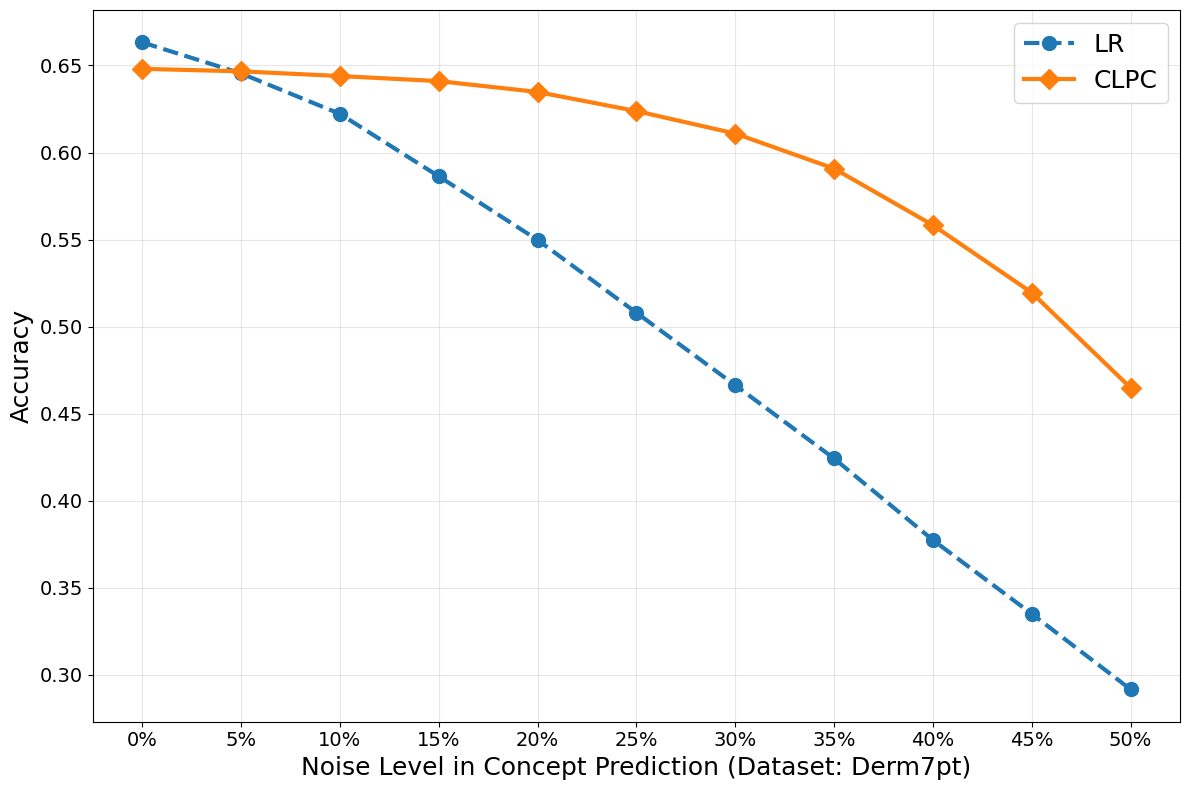

In [59]:
import matplotlib.pyplot as plt

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Plot each algorithm's results
plt.plot(noise_levels, lr_results, marker='o', linestyle='--', label='LR', linewidth=3, markersize=10)
# plt.plot(noise_levels, class_results, marker='D', linestyle='--', label='CLC-D')
plt.plot(noise_levels, proto_results, marker='D', linestyle='-', label='CLPC', linewidth=3, markersize=10)

plt.grid(True, alpha=0.3)
plt.xlabel(f'Noise Level in Concept Prediction (Dataset: {use_dataset})', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
# plt.title(f'Model Performance vs. Noise Level ({use_dataset} Dataset)', fontsize=16)

# Set y-axis limits from 0 to 1
# plt.ylim(0, 0.7)

# Format x-axis ticks as percentages
plt.xticks(noise_levels, [f'{nl*100:.0f}%' for nl in noise_levels], fontsize=14)
plt.yticks(fontsize=14)

# Add a horizontal line for random chance accuracy (1/num_classes)
# random_chance = 1/num_classes
# plt.axhline(y=random_chance, color='r', linestyle='--', alpha=0.7,
#             label=f'Random Chance ({random_chance:.3f})')
plt.legend(fontsize=18)

plt.tight_layout()
output_dir = os.path.join(PROJECT_ROOT, 'output', 'plots')
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, f'{use_dataset}_noise.png'), dpi=600, bbox_inches='tight')
plt.show()

In [60]:
# proto_results